<a href="https://colab.research.google.com/github/ganler/2StreamConvNet-for-single-channel-series/blob/master/%E5%A4%9A%E5%AA%92%E4%BD%93%E5%A4%A7%E4%BD%9C%E4%B8%9A%E5%AE%9E%E8%B7%B5%E6%8A%A5%E5%91%8A%E4%B8%8E%E4%BB%A3%E7%A0%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 多媒体大作业实践报告与代码

> By: 刘佳伟 & 温鑫 

> $26^{th} April$

> If you want to support our work, your star on our Github repo will be a great encouragement to us. [GitHub link](https://github.com/ganler/2StreamConvNet-for-single-channel-series). 

> Many many thanks.



## Brief introduction

Two stream convNet is a famous CNN architecture series in action recognition. The former 2 stream convNet implementations are mainly based on RGB frame series(input of 3*len(series)), which cannot use some strong pretrained model(e.g. ResNet-50) in image recognition(input of 3 channel only).

In some cases, we do action recognition with frames of 1 channels(gray pics, dynamic vision sensor(DVS) pics). If you want to test how pretrained image recognition models works on single channel action recognition, this repo will help you. But attention that the length of input single channel series must be 3(as RGB image has only 3 channels). I also provide few simple data to test if the code works.(At least, it works on my MacOS). To be honest, the code is not that hard to write, as PyTorch provided a user-friendly API.(The most tricky part is the dataloader and the arrangement of files.)

> 简单来说，我们把DVS产生的连续帧数据整合成了3-frame的图片，作为一些image-recognition pre-trained 模型的输入。其中我们使用了`UCF-50`的DVS数据集，并从中抽取了3类，分别代表：
- 唱（吉他弹唱）
- 跳（跳水）
- 篮球

(如果您并不清楚下图的内涵，请忽略之。If you're not familiar with the following image, please ignore it.)

![](http://wx1.sinaimg.cn/large/006APoFYly1g1uo54vnzyg303s06dwxw.gif)


## 环境和流程 Environment and pipelines

### 环境 Environment

- 使用Google的Colab即可(可以使用免费的GPU/CPU/TPU)；
- 若是自己配置环境则需要：
  - `PyTorch 1.0.0` based on `Python3.6+`
  - `Numpy & Pandas & PIL`

### 流程 & 代码整体思路 pipelines

- Prepare Dataset files
- Split the data into train/valid/test(Generate a .csv for each)
- Load data via custom dataloader
- Train pretrained models
- See the results

> Easy and funny, right ?

## Let us play with the codes ~

### Prepare Dataset files

（We have transfered our DVS data into gray image data）

We set our dataset in following file format:

```
- DataSet/
	- class_0/
		- sample_0/
          - frames(images)
		- sample_1/
		...
		- sample_N/
	- class_1/
	...
	- class_N/
```



In [0]:
# Download the dataset we prepared via the following codes.

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1mbz7Oym-plR3ucMiA4t911WRs62sLglw',
                                    dest_path='./DataSet.zip',
                                    unzip = True)

### Import packages

In [0]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn

import torchvision.models as models
from torch.utils import model_zoo
from torchvision import transforms

### Split the data into train/valid/test(Generate a .csv for each)

In [0]:
# 提前声明一些配置参数

'''
假设我们的数据格式是这样：
-DataSet
    - class_0
        - sample_0
                - xxx.png
                ...
                ...
        - sample_1
        ...
    - class_1
        ...
    ...
    - class_N
本段代码最后生成3个csv文件，分别是
- train.csv,
- valid.csv,
- test.csv
'''

# ==========================================
_dict = {'frame_0':[], 'frame_1':[], 'frame_2':[], 'tags': []}


# 数据集母文件的路径
dataset_loc = 'DataSet/'


# 即将产生的csv的路径
train_csv = 'train.csv'
valid_csv = 'valid.csv'
test_csv = 'test.csv'


# Train, Test, Validation的比例
split_pro = [0.7, 0.3, 0]

In [0]:
# 定义划分数据集的函数
# ATTENTION: 请保证sample_i中的图片是按顺序的
def csv_generate(split, shuffle=True):
    # shuffle代表是否打乱（默认打乱）
    if not os.path.exists(dataset_loc): # 没找到数据集，需要返回上面步骤进行下载。
        print(f'{dataset_loc} not found. Downloading dataset. ({dataset_loc} 不存在')
    
    for root, s_dirs, _ in os.walk(dataset_loc, topdown=True):
        for sub_dir in s_dirs:
            if str(sub_dir)[0] != 'c' and str(sub_dir)[0] != 'C': # 如果类别文件夹不以C/c开头则跳过
                continue
            tag = str(sub_dir).split('_')[1]                     # tag = class_N中的N
            class_dir = os.path.join(root, sub_dir)              # class_dir 是class_x的folder的位置
            video_dir_list = os.listdir(class_dir)               # 其中的sample
            for i in range(len(video_dir_list)):
                this_sample_dir = str(class_dir) + '/' + str(video_dir_list[i])
                sample_list = os.listdir(this_sample_dir)        # 图片列表
                sample_list.sort(key=lambda x:int(x[:-4]))
                if len(sample_list) == 0:                        # 检查文件夹是否为空
                    print(this_sample_dir + ' -> is empty')
                for j in range(len(sample_list)-2):
                    if sample_list:
                        _dict['frame_0'].append(
                            this_sample_dir + '/' + str(sample_list[j]))
                        _dict['frame_1'].append(
                            this_sample_dir + '/' + str(sample_list[j+1]))
                        _dict['frame_2'].append(
                            this_sample_dir + '/' + str(sample_list[j+2]))
                    else:
                        _dict['s_frame_0'].append('null')
                        _dict['s_frame_1'].append('null')
                        _dict['s_frame_2'].append('null')
                    _dict['tags'].append(tag)
    if os.path.exists(dataset_loc):
        # 打乱并切分
        df = pd.DataFrame(_dict).sample(frac=shuffle)

        if shuffle:
            df = df.reset_index()

        train = df.loc[0 : int(split[0]*len(df))]

        valid = df.loc[int(split[0]*len(df)) : int(len(df)*(split[0]+split[1]))]

        test = df.loc[int((split[0]+split[1])*len(df)) : len(df)-1]

        train.to_csv(train_csv)
        valid.to_csv(valid_csv)
        test.to_csv(test_csv)

In [0]:
# Generate train/
csv_generate(split_pro)

### Load data via custom dataloader

In [0]:
class DVS_PNG_DATASET(torch.utils.data.Dataset):
    def __init__(self, csv_path, transform=transforms.ToTensor()):
        tmp_df = pd.read_csv(csv_path)
        self.transform = transform
        self.channels = [tmp_df['frame_0'], tmp_df['frame_1'], tmp_df['frame_2']]
        self.labels = tmp_df['tags'].astype(np.int32)
    
    def __getitem__(self, index):
        img0 = Image.open(self.channels[0][index]).convert('L')
        img1 = Image.open(self.channels[1][index]).convert('L')
        img2 = Image.open(self.channels[2][index]).convert('L')
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        src = torch.cat([img0, img1, img2], 0)
        label = torch.from_numpy(np.array(self.labels[index])).long()
        return src, label
        
    def __len__(self):
        return len(self.labels.index)

### Train our network !

#### Hyper parameters

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 3
learning_rate = 0.001
batch_size = 32
num_classes = 3
print_len = 30
wd = 1e-3

criterion = nn.CrossEntropyLoss()

custom_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

train_dataset = DVS_PNG_DATASET('train.csv', custom_transform)
valid_dataset = DVS_PNG_DATASET('valid.csv', custom_transform)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False
)

In [0]:
# Build some utilities;
# 建立一些方便训练的函数

# 打印模板
train_template = '>>> {} === Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
test_template = '\n>>> {} === Test Accuracy of the model on the {} test samples: {} %\n'

def make_new_pretrained_model(pre_model):
    ret_model = pre_model
    ret_model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    pre_dict = pre_model.state_dict()
    ret_dict = ret_model.state_dict()
    
    update_dict = {k: v for k, v in pre_dict.items() if k in ret_dict}
    ret_dict.update(update_dict)
    
    return ret_model

def make_new_pretrained_model_vgg(pre_model):
    ret_model = copy.deepcopy(pre_model)
    ret_model.classifier._modules['6'] = nn.Linear(model.classifier._modules['6'].in_features, num_classes)
    
    pre_dict = pre_model.state_dict()
    ret_dict = ret_model.state_dict()
    
    update_dict = {k: v for k, v in pre_dict.items() if k in ret_dict}
    ret_dict.update(update_dict)
    
    return ret_model
  
def make_new_pretrained_model_dense(pre_model):
    ret_model = copy.deepcopy(pre_model)
    ret_model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    
    pre_dict = pre_model.state_dict()
    ret_dict = ret_model.state_dict()
    
    update_dict = {k: v for k, v in pre_dict.items() if k in ret_dict}
    ret_dict.update(update_dict)
    
    return ret_model
  
def train_it(train_data, train_model, optimizer, loss_list, log = ''):
    train_model = train_model.to(device)
    total_steps = len(train_data)
    for ep in range(num_epochs):
        for i, (x, y) in enumerate(train_data):
            if device.type == 'cuda':
                torch.cuda.empty_cache()

            x = x.to(device)
            y = y.to(device)
            if 'Inception' in log:
                out, aux = train_model(x)
                loss1 = criterion(out, y)
                loss2 = criterion(aux, y)
                loss = loss1 + 0.4*loss2
            else:
                out = train_model(x)
                loss = criterion(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            if (i + 1) % print_len == 0:
                print(
                    train_template.format(
                        log, ep+1, num_epochs, i+1, total_steps, loss.item()
                    ))

def test_it(test_data, test_model, accuracy_list, log = ''):
    test_model = test_model.to(device)
    test_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for x, y in test_data:
            if device.type == 'cuda':
                torch.cuda.empty_cache()
                
            x = x.to(device)
            y = y.to(device)

            out = test_model(x)
                
            _, pre = torch.max(out.data, 1)
            total += y.size(0)
            correct += (y == pre).sum().item()
    accuracy_list.append(correct / total)
    print(test_template.format(log, total, 100 * correct / total))
    
def save_results(loss_list, accuracy_list, name):
    plt.plot(range(0, len(loss_list)), loss_list)
    file = open(name + '_loss.txt','w')  
    file.write(str(loss_list));  
    file.close()
    file = open(name + '_accuracy.txt','w')  
    file.write(str(accuracy_list));  
    file.close()

#### Pretrained ResNet


##### with frozen parameters

- ResNet18

In [9]:
# RESNET
model = models.resnet18(pretrained=True)
# model = models.resnet50(pretrained=True)
# model = models.resnet152(pretrained=True)

name = 'Frozen_ResNet18'
frozen_resnet = make_new_pretrained_model(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []
if(train_again or not os.path.exists(name+'.ckpt')):
    # Frozen params:
    for para in list(frozen_resnet.parameters())[:-2]:
        para.requires_grad = False

    opt = torch.optim.Adamax(
        params=[frozen_resnet.fc.weight, frozen_resnet.fc.bias],
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, frozen_resnet, opt, loss_list, name)
else:
    frozen_resnet.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, frozen_resnet, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(frozen_resnet.state_dict(), name+'.ckpt')
    
del model

>>> Frozen_ResNet18 === Epoch [1/3], Step [30/126], Loss: 0.6844
>>> Frozen_ResNet18 === Epoch [1/3], Step [60/126], Loss: 0.5307
>>> Frozen_ResNet18 === Epoch [1/3], Step [90/126], Loss: 0.4335
>>> Frozen_ResNet18 === Epoch [1/3], Step [120/126], Loss: 0.4718
>>> Frozen_ResNet18 === Epoch [2/3], Step [30/126], Loss: 0.3015
>>> Frozen_ResNet18 === Epoch [2/3], Step [60/126], Loss: 0.2950
>>> Frozen_ResNet18 === Epoch [2/3], Step [90/126], Loss: 0.2968
>>> Frozen_ResNet18 === Epoch [2/3], Step [120/126], Loss: 0.3239
>>> Frozen_ResNet18 === Epoch [3/3], Step [30/126], Loss: 0.3732
>>> Frozen_ResNet18 === Epoch [3/3], Step [60/126], Loss: 0.4075
>>> Frozen_ResNet18 === Epoch [3/3], Step [90/126], Loss: 0.4751
>>> Frozen_ResNet18 === Epoch [3/3], Step [120/126], Loss: 0.4231

>>> Frozen_ResNet18 === Test Accuracy of the model on the 1728 test samples: 92.24537037037037 %



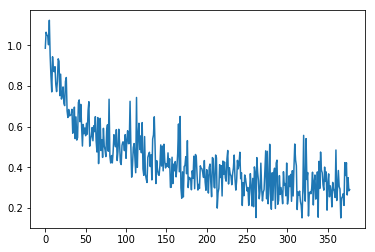

In [10]:
save_results(loss_list, accuracy_list, name)

- ResNet50

In [11]:
# RESNET
# model = models.resnet18(pretrained=True)
model = models.resnet50(pretrained=True)
# model = models.resnet152(pretrained=True)

name = 'Frozen_ResNet50'
frozen_resnet = make_new_pretrained_model(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []
if(train_again or not os.path.exists(name+'.ckpt')):
    # Frozen params:
    for para in list(frozen_resnet.parameters())[:-2]:
        para.requires_grad = False

    opt = torch.optim.Adamax(
        params=[frozen_resnet.fc.weight, frozen_resnet.fc.bias],
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, frozen_resnet, opt, loss_list, name)
else:
    frozen_resnet.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, frozen_resnet, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(frozen_resnet.state_dict(), name+'.ckpt')

del model

>>> Frozen_ResNet50 === Epoch [1/3], Step [30/126], Loss: 0.6421
>>> Frozen_ResNet50 === Epoch [1/3], Step [60/126], Loss: 0.5380
>>> Frozen_ResNet50 === Epoch [1/3], Step [90/126], Loss: 0.4147
>>> Frozen_ResNet50 === Epoch [1/3], Step [120/126], Loss: 0.3405
>>> Frozen_ResNet50 === Epoch [2/3], Step [30/126], Loss: 0.4990
>>> Frozen_ResNet50 === Epoch [2/3], Step [60/126], Loss: 0.5048
>>> Frozen_ResNet50 === Epoch [2/3], Step [90/126], Loss: 0.3469
>>> Frozen_ResNet50 === Epoch [2/3], Step [120/126], Loss: 0.6094
>>> Frozen_ResNet50 === Epoch [3/3], Step [30/126], Loss: 0.3270
>>> Frozen_ResNet50 === Epoch [3/3], Step [60/126], Loss: 0.4202
>>> Frozen_ResNet50 === Epoch [3/3], Step [90/126], Loss: 0.4199
>>> Frozen_ResNet50 === Epoch [3/3], Step [120/126], Loss: 0.2288

>>> Frozen_ResNet50 === Test Accuracy of the model on the 1728 test samples: 93.98148148148148 %



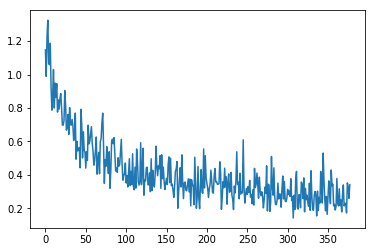

In [12]:
save_results(loss_list, accuracy_list, name)

- ResNet152

In [13]:
# RESNET
# model = models.resnet18(pretrained=True)
# model = models.resnet50(pretrained=True)
model = models.resnet152(pretrained=True)

name = 'Frozen_ResNet152'
frozen_resnet = make_new_pretrained_model(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []
if(train_again or not os.path.exists(name+'.ckpt')):
    # Frozen params:
    for para in list(frozen_resnet.parameters())[:-2]:
        para.requires_grad = False

    opt = torch.optim.Adamax(
        params=[frozen_resnet.fc.weight, frozen_resnet.fc.bias],
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, frozen_resnet, opt, loss_list, name)
else:
    frozen_resnet.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, frozen_resnet, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(frozen_resnet.state_dict(), name+'.ckpt')

del model

>>> Frozen_ResNet152 === Epoch [1/3], Step [30/126], Loss: 0.5746
>>> Frozen_ResNet152 === Epoch [1/3], Step [60/126], Loss: 0.4852
>>> Frozen_ResNet152 === Epoch [1/3], Step [90/126], Loss: 0.6216
>>> Frozen_ResNet152 === Epoch [1/3], Step [120/126], Loss: 0.3938
>>> Frozen_ResNet152 === Epoch [2/3], Step [30/126], Loss: 0.4678
>>> Frozen_ResNet152 === Epoch [2/3], Step [60/126], Loss: 0.4152
>>> Frozen_ResNet152 === Epoch [2/3], Step [90/126], Loss: 0.4822
>>> Frozen_ResNet152 === Epoch [2/3], Step [120/126], Loss: 0.3456
>>> Frozen_ResNet152 === Epoch [3/3], Step [30/126], Loss: 0.3410
>>> Frozen_ResNet152 === Epoch [3/3], Step [60/126], Loss: 0.3047
>>> Frozen_ResNet152 === Epoch [3/3], Step [90/126], Loss: 0.2251
>>> Frozen_ResNet152 === Epoch [3/3], Step [120/126], Loss: 0.3000

>>> Frozen_ResNet152 === Test Accuracy of the model on the 1728 test samples: 92.70833333333333 %



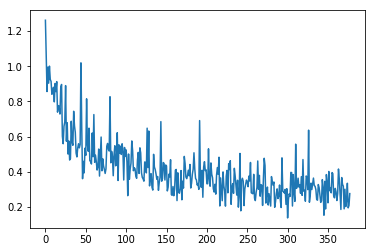

In [14]:
save_results(loss_list, accuracy_list, name)

##### without frozen parameters

- ResNet18

In [15]:
# RESNET
model = models.resnet18(pretrained=True)
# model = models.resnet50(pretrained=True)
# model = models.resnet152(pretrained=True)

name = 'Unfrozen_ResNet18'
unfrozen_resnet = make_new_pretrained_model(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []
if(train_again or not os.path.exists(name+'.ckpt')):
    opt = torch.optim.Adamax(
        unfrozen_resnet.parameters(),
        lr=learning_rate,
        weight_decay=wd
    )

    train_it(train_loader, unfrozen_resnet, opt, loss_list, name)
else:
    unfrozen_resnet.load_state_dict(torch.load(name+'.ckpt'))

test_it(valid_loader, unfrozen_resnet, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(unfrozen_resnet.state_dict(), name+'.ckpt')
    
del model

>>> Unfrozen_ResNet18 === Epoch [1/3], Step [30/126], Loss: 0.1202
>>> Unfrozen_ResNet18 === Epoch [1/3], Step [60/126], Loss: 0.0096
>>> Unfrozen_ResNet18 === Epoch [1/3], Step [90/126], Loss: 0.0059
>>> Unfrozen_ResNet18 === Epoch [1/3], Step [120/126], Loss: 0.0025
>>> Unfrozen_ResNet18 === Epoch [2/3], Step [30/126], Loss: 0.0016
>>> Unfrozen_ResNet18 === Epoch [2/3], Step [60/126], Loss: 0.0015
>>> Unfrozen_ResNet18 === Epoch [2/3], Step [90/126], Loss: 0.0118
>>> Unfrozen_ResNet18 === Epoch [2/3], Step [120/126], Loss: 0.0018
>>> Unfrozen_ResNet18 === Epoch [3/3], Step [30/126], Loss: 0.0005
>>> Unfrozen_ResNet18 === Epoch [3/3], Step [60/126], Loss: 0.0002
>>> Unfrozen_ResNet18 === Epoch [3/3], Step [90/126], Loss: 0.0033
>>> Unfrozen_ResNet18 === Epoch [3/3], Step [120/126], Loss: 0.0017

>>> Unfrozen_ResNet18 === Test Accuracy of the model on the 1728 test samples: 100.0 %



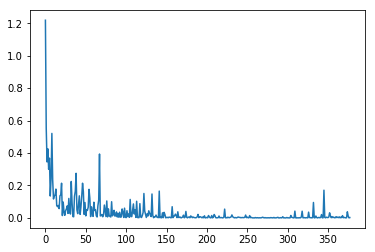

In [16]:
save_results(loss_list, accuracy_list, name)

- ResNet50

In [17]:
# RESNET
# model = models.resnet18(pretrained=True)
model = models.resnet50(pretrained=True)
# model = models.resnet152(pretrained=True)

name = 'Unfrozen_ResNet50'
unfrozen_resnet = make_new_pretrained_model(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []
if(train_again or not os.path.exists(name+'.ckpt')):
    opt = torch.optim.Adamax(
        unfrozen_resnet.parameters(),
        lr=learning_rate,
        weight_decay=wd
    )
    train_it(train_loader, unfrozen_resnet, opt, loss_list, name)
else:
    unfrozen_resnet.load_state_dict(torch.load(name+'.ckpt'))

test_it(valid_loader, unfrozen_resnet, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(unfrozen_resnet.state_dict(), name+'.ckpt')

del model

>>> Unfrozen_ResNet50 === Epoch [1/3], Step [30/126], Loss: 0.0680
>>> Unfrozen_ResNet50 === Epoch [1/3], Step [60/126], Loss: 0.1470
>>> Unfrozen_ResNet50 === Epoch [1/3], Step [90/126], Loss: 0.0036
>>> Unfrozen_ResNet50 === Epoch [1/3], Step [120/126], Loss: 0.0304
>>> Unfrozen_ResNet50 === Epoch [2/3], Step [30/126], Loss: 0.0040
>>> Unfrozen_ResNet50 === Epoch [2/3], Step [60/126], Loss: 0.0660
>>> Unfrozen_ResNet50 === Epoch [2/3], Step [90/126], Loss: 0.0069
>>> Unfrozen_ResNet50 === Epoch [2/3], Step [120/126], Loss: 0.0504
>>> Unfrozen_ResNet50 === Epoch [3/3], Step [30/126], Loss: 0.0027
>>> Unfrozen_ResNet50 === Epoch [3/3], Step [60/126], Loss: 0.0468
>>> Unfrozen_ResNet50 === Epoch [3/3], Step [90/126], Loss: 0.0687
>>> Unfrozen_ResNet50 === Epoch [3/3], Step [120/126], Loss: 0.0099

>>> Unfrozen_ResNet50 === Test Accuracy of the model on the 1728 test samples: 98.90046296296296 %



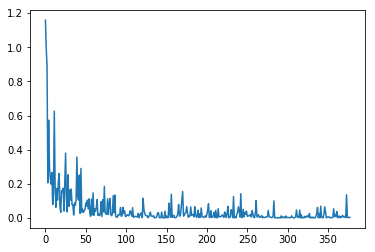

In [18]:
save_results(loss_list, accuracy_list, name)

- ResNet152

In [19]:
# RESNET
# model = models.resnet18(pretrained=True)
# model = models.resnet50(pretrained=True)
model = models.resnet152(pretrained=True)

name = 'Unfrozen_ResNet152'
unfrozen_resnet = make_new_pretrained_model(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []
if(train_again or not os.path.exists(name+'.ckpt')):
    opt = torch.optim.Adamax(
        unfrozen_resnet.parameters(),
        lr=learning_rate,
        weight_decay=wd
    )
    train_it(train_loader, unfrozen_resnet, opt, loss_list, name)
else:
    unfrozen_resnet.load_state_dict(torch.load(name+'.ckpt'))

test_it(valid_loader, unfrozen_resnet, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(unfrozen_resnet.state_dict(), name+'.ckpt')

del model

>>> Unfrozen_ResNet152 === Epoch [1/3], Step [30/126], Loss: 0.2576
>>> Unfrozen_ResNet152 === Epoch [1/3], Step [60/126], Loss: 0.2117
>>> Unfrozen_ResNet152 === Epoch [1/3], Step [90/126], Loss: 0.0663
>>> Unfrozen_ResNet152 === Epoch [1/3], Step [120/126], Loss: 0.0052
>>> Unfrozen_ResNet152 === Epoch [2/3], Step [30/126], Loss: 0.0173
>>> Unfrozen_ResNet152 === Epoch [2/3], Step [60/126], Loss: 0.0110
>>> Unfrozen_ResNet152 === Epoch [2/3], Step [90/126], Loss: 0.0217
>>> Unfrozen_ResNet152 === Epoch [2/3], Step [120/126], Loss: 0.0268
>>> Unfrozen_ResNet152 === Epoch [3/3], Step [30/126], Loss: 0.0691
>>> Unfrozen_ResNet152 === Epoch [3/3], Step [60/126], Loss: 0.0828
>>> Unfrozen_ResNet152 === Epoch [3/3], Step [90/126], Loss: 0.0550
>>> Unfrozen_ResNet152 === Epoch [3/3], Step [120/126], Loss: 0.0083

>>> Unfrozen_ResNet152 === Test Accuracy of the model on the 1728 test samples: 99.53703703703704 %



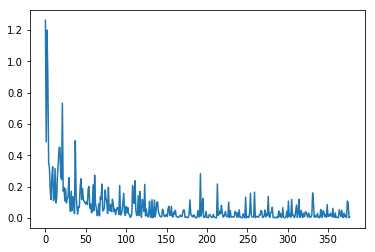

In [20]:
save_results(loss_list, accuracy_list, name)

#### Pretrained VGG

##### with frozen parameters

In [21]:
# VGG
model = models.vgg19(pretrained=True)

name = 'Frozen_VGG19'
frozen_vgg = make_new_pretrained_model_vgg(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []

if(train_again or not os.path.exists(name+'.ckpt')):
    # Frozen params:
    for para in list(frozen_vgg.parameters())[:-2]:
        para.requires_grad = False

    opt = torch.optim.Adamax(
        params=[frozen_vgg.classifier._modules['6'].weight, frozen_vgg.classifier._modules['6'].bias],
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, frozen_vgg, opt, loss_list, name)
else:
    frozen_vgg.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, frozen_vgg, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(frozen_vgg.state_dict(), name+'.ckpt')

del model

>>> Frozen_VGG19 === Epoch [1/3], Step [30/126], Loss: 0.2987
>>> Frozen_VGG19 === Epoch [1/3], Step [60/126], Loss: 0.2516
>>> Frozen_VGG19 === Epoch [1/3], Step [90/126], Loss: 0.5167
>>> Frozen_VGG19 === Epoch [1/3], Step [120/126], Loss: 0.2538
>>> Frozen_VGG19 === Epoch [2/3], Step [30/126], Loss: 0.1979
>>> Frozen_VGG19 === Epoch [2/3], Step [60/126], Loss: 0.2153
>>> Frozen_VGG19 === Epoch [2/3], Step [90/126], Loss: 0.1498
>>> Frozen_VGG19 === Epoch [2/3], Step [120/126], Loss: 0.1855
>>> Frozen_VGG19 === Epoch [3/3], Step [30/126], Loss: 0.2354
>>> Frozen_VGG19 === Epoch [3/3], Step [60/126], Loss: 0.1426
>>> Frozen_VGG19 === Epoch [3/3], Step [90/126], Loss: 0.1308
>>> Frozen_VGG19 === Epoch [3/3], Step [120/126], Loss: 0.1405

>>> Frozen_VGG19 === Test Accuracy of the model on the 1728 test samples: 94.27083333333333 %



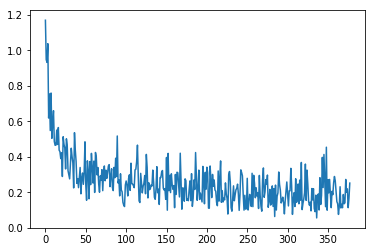

In [22]:
save_results(loss_list, accuracy_list, name)

##### without frozen parameters

In [23]:
# VGG
model = models.vgg19(pretrained=True)

name = 'Unfrozen_VGG19'
un_frozen_vgg = make_new_pretrained_model_vgg(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []

if(train_again or not os.path.exists(name+'.ckpt')):
    opt = torch.optim.Adamax(
        un_frozen_vgg.parameters(),
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, un_frozen_vgg, opt, loss_list, name)
else:
    un_frozen_vgg.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, un_frozen_vgg, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(un_frozen_vgg.state_dict(), name+'.ckpt')

del model

>>> Unfrozen_VGG19 === Epoch [1/3], Step [30/126], Loss: 0.7073
>>> Unfrozen_VGG19 === Epoch [1/3], Step [60/126], Loss: 0.4979
>>> Unfrozen_VGG19 === Epoch [1/3], Step [90/126], Loss: 0.2368
>>> Unfrozen_VGG19 === Epoch [1/3], Step [120/126], Loss: 0.1926
>>> Unfrozen_VGG19 === Epoch [2/3], Step [30/126], Loss: 0.2107
>>> Unfrozen_VGG19 === Epoch [2/3], Step [60/126], Loss: 0.0548
>>> Unfrozen_VGG19 === Epoch [2/3], Step [90/126], Loss: 0.1845
>>> Unfrozen_VGG19 === Epoch [2/3], Step [120/126], Loss: 0.0622
>>> Unfrozen_VGG19 === Epoch [3/3], Step [30/126], Loss: 0.0301
>>> Unfrozen_VGG19 === Epoch [3/3], Step [60/126], Loss: 0.0260
>>> Unfrozen_VGG19 === Epoch [3/3], Step [90/126], Loss: 0.0444
>>> Unfrozen_VGG19 === Epoch [3/3], Step [120/126], Loss: 0.2015

>>> Unfrozen_VGG19 === Test Accuracy of the model on the 1728 test samples: 97.68518518518519 %



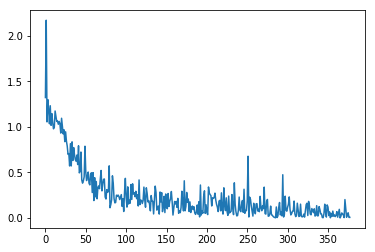

In [24]:
save_results(loss_list, accuracy_list, name)

#### Pretrained DenseNet

##### with frozen parameters

- DenseNet121

In [25]:
# DenseNet
model = models.densenet121(pretrained=True)
# model = models.densenet161(pretrained=True)

name = 'Frozen_DenseNet121'
frozen_dense = make_new_pretrained_model_dense(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []

if(train_again or not os.path.exists(name+'.ckpt')):
    # Frozen params:
    for para in list(frozen_dense.parameters())[:-2]:
        para.requires_grad = False

    opt = torch.optim.Adamax(
        params=[frozen_dense.classifier.weight, frozen_dense.classifier.bias],
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, frozen_dense, opt, loss_list, name)
else:
    frozen_dense.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, frozen_dense, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(frozen_dense.state_dict(), name+'.ckpt')

del model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
32342954it [00:01, 26962322.71it/s]


>>> Frozen_DenseNet121 === Epoch [1/3], Step [30/126], Loss: 0.7808
>>> Frozen_DenseNet121 === Epoch [1/3], Step [60/126], Loss: 0.4720
>>> Frozen_DenseNet121 === Epoch [1/3], Step [90/126], Loss: 0.3873
>>> Frozen_DenseNet121 === Epoch [1/3], Step [120/126], Loss: 0.4665
>>> Frozen_DenseNet121 === Epoch [2/3], Step [30/126], Loss: 0.3384
>>> Frozen_DenseNet121 === Epoch [2/3], Step [60/126], Loss: 0.4794
>>> Frozen_DenseNet121 === Epoch [2/3], Step [90/126], Loss: 0.3457
>>> Frozen_DenseNet121 === Epoch [2/3], Step [120/126], Loss: 0.2499
>>> Frozen_DenseNet121 === Epoch [3/3], Step [30/126], Loss: 0.2775
>>> Frozen_DenseNet121 === Epoch [3/3], Step [60/126], Loss: 0.3050
>>> Frozen_DenseNet121 === Epoch [3/3], Step [90/126], Loss: 0.4342
>>> Frozen_DenseNet121 === Epoch [3/3], Step [120/126], Loss: 0.3412

>>> Frozen_DenseNet121 === Test Accuracy of the model on the 1728 test samples: 91.72453703703704 %



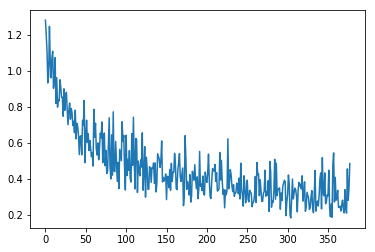

In [26]:
save_results(loss_list, accuracy_list, name)

- DenseNet161

In [27]:
# DenseNet
# model = models.densenet121(pretrained=True)
model = models.densenet161(pretrained=True)

name = 'Frozen_DenseNet161'
frozen_dense = make_new_pretrained_model_dense(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []

if(train_again or not os.path.exists(name+'.ckpt')):
    # Frozen params:
    for para in list(frozen_dense.parameters())[:-2]:
        para.requires_grad = False

    opt = torch.optim.Adamax(
        params=[frozen_dense.classifier.weight, frozen_dense.classifier.bias],
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, frozen_dense, opt, loss_list, name)
else:
    frozen_dense.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, frozen_dense, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(frozen_dense.state_dict(), name+'.ckpt')

del model

>>> Frozen_DenseNet161 === Epoch [1/3], Step [30/126], Loss: 0.6077
>>> Frozen_DenseNet161 === Epoch [1/3], Step [60/126], Loss: 0.4325
>>> Frozen_DenseNet161 === Epoch [1/3], Step [90/126], Loss: 0.4809
>>> Frozen_DenseNet161 === Epoch [1/3], Step [120/126], Loss: 0.4179
>>> Frozen_DenseNet161 === Epoch [2/3], Step [30/126], Loss: 0.4885
>>> Frozen_DenseNet161 === Epoch [2/3], Step [60/126], Loss: 0.3579
>>> Frozen_DenseNet161 === Epoch [2/3], Step [90/126], Loss: 0.2624
>>> Frozen_DenseNet161 === Epoch [2/3], Step [120/126], Loss: 0.1885
>>> Frozen_DenseNet161 === Epoch [3/3], Step [30/126], Loss: 0.2525
>>> Frozen_DenseNet161 === Epoch [3/3], Step [60/126], Loss: 0.1808
>>> Frozen_DenseNet161 === Epoch [3/3], Step [90/126], Loss: 0.2705
>>> Frozen_DenseNet161 === Epoch [3/3], Step [120/126], Loss: 0.4619

>>> Frozen_DenseNet161 === Test Accuracy of the model on the 1728 test samples: 93.98148148148148 %



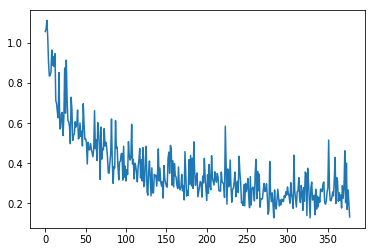

In [28]:
save_results(loss_list, accuracy_list, name)

##### without frozen parameters

- DenseNet121

In [29]:
# DenseNet
model = models.densenet121(pretrained=True)
# model = models.densenet161(pretrained=True)

name = 'Unfrozen_DenseNet121'
un_frozen_dense = make_new_pretrained_model_dense(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []

if(train_again or not os.path.exists(name+'.ckpt')):
    opt = torch.optim.Adamax(
        un_frozen_dense.parameters(),
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, un_frozen_dense, opt, loss_list, name)
else:
    un_frozen_dense.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, un_frozen_dense, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(un_frozen_dense.state_dict(), name+'.ckpt')

del model

>>> Unfrozen_DenseNet121 === Epoch [1/3], Step [30/126], Loss: 0.0722
>>> Unfrozen_DenseNet121 === Epoch [1/3], Step [60/126], Loss: 0.0147
>>> Unfrozen_DenseNet121 === Epoch [1/3], Step [90/126], Loss: 0.0102
>>> Unfrozen_DenseNet121 === Epoch [1/3], Step [120/126], Loss: 0.0158
>>> Unfrozen_DenseNet121 === Epoch [2/3], Step [30/126], Loss: 0.0035
>>> Unfrozen_DenseNet121 === Epoch [2/3], Step [60/126], Loss: 0.0065
>>> Unfrozen_DenseNet121 === Epoch [2/3], Step [90/126], Loss: 0.0051
>>> Unfrozen_DenseNet121 === Epoch [2/3], Step [120/126], Loss: 0.0186
>>> Unfrozen_DenseNet121 === Epoch [3/3], Step [30/126], Loss: 0.0045
>>> Unfrozen_DenseNet121 === Epoch [3/3], Step [60/126], Loss: 0.0113
>>> Unfrozen_DenseNet121 === Epoch [3/3], Step [90/126], Loss: 0.0503
>>> Unfrozen_DenseNet121 === Epoch [3/3], Step [120/126], Loss: 0.0120

>>> Unfrozen_DenseNet121 === Test Accuracy of the model on the 1728 test samples: 99.88425925925925 %



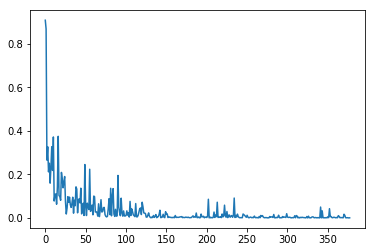

In [30]:
save_results(loss_list, accuracy_list, name)

- DenseNet161

In [31]:
# DenseNet
# model = models.densenet121(pretrained=True)
model = models.densenet161(pretrained=True)

name = 'Unfrozen_DenseNet161'
un_frozen_dense = make_new_pretrained_model_dense(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []

if(train_again or not os.path.exists(name+'.ckpt')):
    opt = torch.optim.Adamax(
        un_frozen_dense.parameters(),
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(train_loader, un_frozen_dense, opt, loss_list, name)
else:
    un_frozen_dense.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(valid_loader, un_frozen_dense, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(un_frozen_dense.state_dict(), name+'.ckpt')

del model

>>> Unfrozen_DenseNet161 === Epoch [1/3], Step [30/126], Loss: 0.0656
>>> Unfrozen_DenseNet161 === Epoch [1/3], Step [60/126], Loss: 0.0892
>>> Unfrozen_DenseNet161 === Epoch [1/3], Step [90/126], Loss: 0.0488
>>> Unfrozen_DenseNet161 === Epoch [1/3], Step [120/126], Loss: 0.0240
>>> Unfrozen_DenseNet161 === Epoch [2/3], Step [30/126], Loss: 0.0152
>>> Unfrozen_DenseNet161 === Epoch [2/3], Step [60/126], Loss: 0.0011
>>> Unfrozen_DenseNet161 === Epoch [2/3], Step [90/126], Loss: 0.0270
>>> Unfrozen_DenseNet161 === Epoch [2/3], Step [120/126], Loss: 0.0039
>>> Unfrozen_DenseNet161 === Epoch [3/3], Step [30/126], Loss: 0.0045
>>> Unfrozen_DenseNet161 === Epoch [3/3], Step [60/126], Loss: 0.0090
>>> Unfrozen_DenseNet161 === Epoch [3/3], Step [90/126], Loss: 0.0017
>>> Unfrozen_DenseNet161 === Epoch [3/3], Step [120/126], Loss: 0.0011

>>> Unfrozen_DenseNet161 === Test Accuracy of the model on the 1728 test samples: 99.76851851851852 %



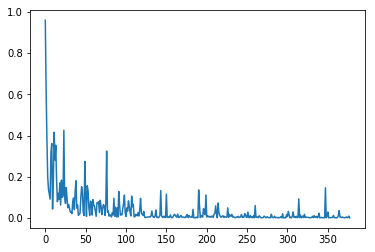

In [32]:
save_results(loss_list, accuracy_list, name)

#### Pretrained Inception v3

In [0]:
# Input scale of Inception v3 is uniquely 299 by 299.

incep_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor()
])

incep_train_dataset = DVS_PNG_DATASET('train.csv', incep_transform)
incep_valid_dataset = DVS_PNG_DATASET('valid.csv', incep_transform)

incep_train_loader = torch.utils.data.DataLoader(
    dataset=incep_train_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
)

incep_valid_loader = torch.utils.data.DataLoader(
    dataset=incep_valid_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False
)

##### with frozen parameters

In [38]:
# Inception v3
model = models.inception_v3(pretrained=True)

name = 'Frozen_Inception_v3'
frozen_inception = make_new_pretrained_model(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []

if(train_again or not os.path.exists(name+'.ckpt')):
    # Frozen params:
    for para in list(frozen_inception.parameters())[:-2]:
        para.requires_grad = False

    opt = torch.optim.Adamax(
        params=[frozen_inception.fc.weight, frozen_inception.fc.bias],
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(incep_train_loader, frozen_inception, opt, loss_list, name)
else:
    frozen_inception.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(incep_valid_loader, frozen_inception, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(frozen_inception.state_dict(), name+'.ckpt')

del model

>>> Frozen_Inception_v3 === Epoch [1/3], Step [30/126], Loss: 3.9574
>>> Frozen_Inception_v3 === Epoch [1/3], Step [60/126], Loss: 3.7839
>>> Frozen_Inception_v3 === Epoch [1/3], Step [90/126], Loss: 3.6700
>>> Frozen_Inception_v3 === Epoch [1/3], Step [120/126], Loss: 3.6741
>>> Frozen_Inception_v3 === Epoch [2/3], Step [30/126], Loss: 3.6718
>>> Frozen_Inception_v3 === Epoch [2/3], Step [60/126], Loss: 3.7577
>>> Frozen_Inception_v3 === Epoch [2/3], Step [90/126], Loss: 3.6074
>>> Frozen_Inception_v3 === Epoch [2/3], Step [120/126], Loss: 3.4191
>>> Frozen_Inception_v3 === Epoch [3/3], Step [30/126], Loss: 3.3981
>>> Frozen_Inception_v3 === Epoch [3/3], Step [60/126], Loss: 3.5209
>>> Frozen_Inception_v3 === Epoch [3/3], Step [90/126], Loss: 3.2663
>>> Frozen_Inception_v3 === Epoch [3/3], Step [120/126], Loss: 3.5304

>>> Frozen_Inception_v3 === Test Accuracy of the model on the 1728 test samples: 90.27777777777777 %



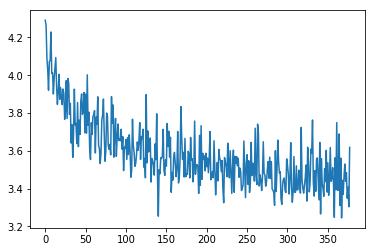

In [39]:
save_results(loss_list, accuracy_list, name)

##### without frozen parameters

In [40]:
# Inception v3
model = models.inception_v3(pretrained=True)

name = 'Unfrozen_Inception_v3'
un_frozen_inception = make_new_pretrained_model(model)

train_again = True # 调整这个来确定是否重新训练
loss_list = []
accuracy_list = []

if(train_again or not os.path.exists(name+'.ckpt')):
    opt = torch.optim.Adamax(
        un_frozen_inception.parameters(),
        lr=learning_rate,
        weight_decay=wd
    )
    
    train_it(incep_train_loader, un_frozen_inception, opt, loss_list, name)
else:
    un_frozen_inception.load_state_dict(torch.load(name+'.ckpt'))
    
test_it(incep_valid_loader, un_frozen_inception, accuracy_list, name)

if(train_again or not os.path.exists(name+'.ckpt')):
    torch.save(un_frozen_inception.state_dict(), name+'.ckpt')

del model

>>> Unfrozen_Inception_v3 === Epoch [1/3], Step [30/126], Loss: 0.1131
>>> Unfrozen_Inception_v3 === Epoch [1/3], Step [60/126], Loss: 0.0213
>>> Unfrozen_Inception_v3 === Epoch [1/3], Step [90/126], Loss: 0.0312
>>> Unfrozen_Inception_v3 === Epoch [1/3], Step [120/126], Loss: 0.1321
>>> Unfrozen_Inception_v3 === Epoch [2/3], Step [30/126], Loss: 0.0103
>>> Unfrozen_Inception_v3 === Epoch [2/3], Step [60/126], Loss: 0.0160
>>> Unfrozen_Inception_v3 === Epoch [2/3], Step [90/126], Loss: 0.0039
>>> Unfrozen_Inception_v3 === Epoch [2/3], Step [120/126], Loss: 0.0161
>>> Unfrozen_Inception_v3 === Epoch [3/3], Step [30/126], Loss: 0.0018
>>> Unfrozen_Inception_v3 === Epoch [3/3], Step [60/126], Loss: 0.0532
>>> Unfrozen_Inception_v3 === Epoch [3/3], Step [90/126], Loss: 0.0045
>>> Unfrozen_Inception_v3 === Epoch [3/3], Step [120/126], Loss: 0.0043

>>> Unfrozen_Inception_v3 === Test Accuracy of the model on the 1728 test samples: 99.5949074074074 %



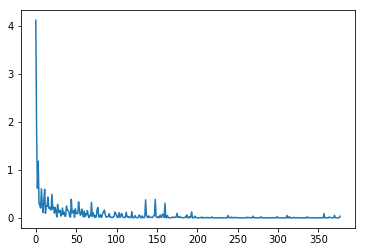

In [41]:
save_results(loss_list, accuracy_list, name)